# 🔍 Predicting Item Prices from Descriptions (Part 3)

# 🔧 **Part 3: Fine-Tuning GPT-4o Mini**

In this final phase, we take GPT-4o Mini and fine-tune it on our curated dataset of item descriptions and prices.
- 🎯 Objective: Fine-tune GPT-4o Mini on our dataset to improve price prediction accuracy.
- 📊 We’ll Compare: Its fine-tuned performance vs. zero-shot results, traditional ML, frontier LLMs, and Ed's human estimates.
- ❓ Key Question: Can GPT-4o Mini beat its own zero-shot baseline — and close the gap with bigger models?

⚙️ Hardware: ✅ CPU is sufficient — no GPU required

🛠️ Requirements: 🔑 Open API Key

📢 Find more LLM notebooks on my GitHub repository: https://github.com/lisek75/nlp_llms_notebook

In [8]:
# imports

import os, sys, pickle, importlib, json, re
from dotenv import load_dotenv
from openai import OpenAI

In [9]:
load_dotenv(override=True)

openai_api_key = os.getenv('OPENAI_API_KEY')
if not openai_api_key: print("❌ OPENAI_API_KEY is missing")
    
openai = OpenAI(api_key=openai_api_key)

# 📥 Load Preprocessed Dataset

In [10]:
# Add helpers path and import Item class
sys.path.append('./helpers')
from helpers import items
from helpers.items import Item

# Load the pickled datasets
with open('data/train.pkl', 'rb') as file:
    train = pickle.load(file)
    
with open('data/test.pkl', 'rb') as file:
    test = pickle.load(file)

# 🛠️ Step 1 : Data Preparation

In [11]:
# OpenAI recommends fine-tuning with populations of 50-100 examples

ft_train = train[:100]
ft_validation = train[100:150]

To fine-tune GPT-4o-mini, OpenAI requires training data in **.jsonl format**. 

`make_jsonl` converts our chat data :

from 

[
  {"role": "system", "content": "You estimate prices of items. Reply only with the price, no explanation"},
  {"role": "user", "content": "How much is this laptop worth?"},
  {"role": "assistant", "content": "Price is $999.00"}
]

into the .jsonl format 

{"messages": [{"role": "system", "content": "You estimate prices of items. Reply only with the price, no explanation"}, {"role": "user", "content": "How much is this laptop worth?"}, {"role": "assistant", "content": "Price is $999.00"}]}


In [12]:
def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": f"Price is ${item.price:.2f}"}
    ]

messages_for(train[0])

[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation'},
 {'role': 'user',
  'content': 'How much does this cost?\n\nDetail King TNT Tire Gel - Vibrant Car Tire Shine - Tire Dressing and Trim Shine - Gallon\nThe TNT Tire Gel is a water-based, silicone gel dressing that gives tires a bright, glossy finish. Easy to apply and durable, this gel is a remarkable product for both auto detailers and car enthusiasts looking to achieve a quick shine on their tires. For Best Results Apply to clean tires. Squeeze a few lines of product onto an Automotive Tire Dressing Applicator. Thoroughly rub into the grooves of your tires. Scrub both horizontally and vertically to reach all crevices. Allow the gel to set into the tires for a half hour before driving. This helps to avoid sling. You’re done! Just a little bit of gel and your tires look brand new'},
 {'role': 'assistant', 'content': 'Price is $129.95'}]

In [13]:
def make_jsonl(items):
    result = ""
    for item in items:
        messages = messages_for(item)
        messages_str = json.dumps(messages)
        result += '{"messages": ' + messages_str +'}\n'
    return result.strip()

print(make_jsonl(train[:1]))

{"messages": [{"role": "system", "content": "You estimate prices of items. Reply only with the price, no explanation"}, {"role": "user", "content": "How much does this cost?\n\nDetail King TNT Tire Gel - Vibrant Car Tire Shine - Tire Dressing and Trim Shine - Gallon\nThe TNT Tire Gel is a water-based, silicone gel dressing that gives tires a bright, glossy finish. Easy to apply and durable, this gel is a remarkable product for both auto detailers and car enthusiasts looking to achieve a quick shine on their tires. For Best Results Apply to clean tires. Squeeze a few lines of product onto an Automotive Tire Dressing Applicator. Thoroughly rub into the grooves of your tires. Scrub both horizontally and vertically to reach all crevices. Allow the gel to set into the tires for a half hour before driving. This helps to avoid sling. You\u2019re done! Just a little bit of gel and your tires look brand new"}, {"role": "assistant", "content": "Price is $129.95"}]}


In [14]:
# Convert the items into jsonl and write them to a file

def write_jsonl(items, filename):
    with open(filename, "w") as f:
        jsonl = make_jsonl(items)
        f.write(jsonl)

In [15]:
write_jsonl(ft_train, "data/ft_train.jsonl")
write_jsonl(ft_validation, "data/ft_val.jsonl")

In [16]:
with open("data/ft_train.jsonl", "rb") as f:
    train_file = openai.files.create(file=f, purpose="fine-tune")
with open("data/ft_val.jsonl", "rb") as f:
    validation_file = openai.files.create(file=f, purpose="fine-tune")

In [17]:
train_file

FileObject(id='file-CNJTuwvmz9y8ZbJVh2k1Ny', bytes=94660, created_at=1743777690, filename='ft_train.jsonl', object='file', purpose='fine-tune', status='processed', expires_at=None, status_details=None)

In [18]:
validation_file

FileObject(id='file-4cJQFpuPqm9jGBveXQmzPB', bytes=47469, created_at=1743777691, filename='ft_val.jsonl', object='file', purpose='fine-tune', status='processed', expires_at=None, status_details=None)

# 🚀 Step 2: Run Fine-Tuning & Monitor with wandb
We will use https://wandb.ai to monitor the training runs

1- Create an API key in wandb

2- Add this key in OpenAI dashboard https://platform.openai.com/account/organization

In [19]:
wandb_integration = {"type": "wandb", "wandb": {"project": "gpt-pricer"}}

In [20]:
# Run the fine tuning

openai.fine_tuning.jobs.create(
    training_file=train_file.id,
    validation_file=validation_file.id,
    model="gpt-4o-mini-2024-07-18",
    seed=42,
    hyperparameters={"n_epochs": 1},
    integrations = [wandb_integration],
    suffix="pricer"
)

FineTuningJob(id='ftjob-DC2dBIsFoHSsXppSR4AHUYD0', created_at=1743777704, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-AalSWqvkkoOsbtYdAVNBKdjL', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-CNJTuwvmz9y8ZbJVh2k1Ny', validation_file='file-4cJQFpuPqm9jGBveXQmzPB', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-DC2dBIsFoHSsXppSR4AHUYD0'))], metadata=None, method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1)), type='supervised'), user_provided_suffix='pricer')

In [21]:
job_id = openai.fine_tuning.jobs.list(limit=1).data[0].id
job_id

# Then check your wandb dashboard to view the run of this job ID

'ftjob-DC2dBIsFoHSsXppSR4AHUYD0'

In [25]:
# Use this command to track the fine-tuning progress here
openai.fine_tuning.jobs.list_events(fine_tuning_job_id=job_id, limit=2).data


[FineTuningJobEvent(id='ftevent-ANGOD7SOxCzm7h7TjftP4kP0', created_at=1743778172, level='info', message='Step 29/100: training loss=0.95, validation loss=1.14', object='fine_tuning.job.event', data={'step': 29, 'train_loss': 0.9536826610565186, 'valid_loss': 1.1373472213745117, 'total_steps': 100, 'train_mean_token_accuracy': 0.875, 'valid_mean_token_accuracy': 0.875}, type='metrics'),
 FineTuningJobEvent(id='ftevent-9A4AFtAtt466ViyWsMLwKJIS', created_at=1743778167, level='info', message='Step 28/100: training loss=1.01, validation loss=0.92', object='fine_tuning.job.event', data={'step': 28, 'train_loss': 1.007530689239502, 'valid_loss': 0.9215812683105469, 'total_steps': 100, 'train_mean_token_accuracy': 0.875, 'valid_mean_token_accuracy': 0.875}, type='metrics')]

# *📧 You’ll get an email once fine-tuning is complete. ☕ You can take a break until then. ▶️ Once you receive it, run the cells below to continue.*

## Step 3 : Test the fine tuned model

In [26]:
ft_model_name = openai.fine_tuning.jobs.retrieve(job_id).fine_tuned_model
ft_model_name

'ft:gpt-4o-mini-2024-07-18:personal:pricer:BIckdoGL'

In [27]:
def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

def gpt_ft(item):
    response = openai.chat.completions.create(
        model=ft_model_name, 
        messages=messages_for(item),
        seed=42,
        max_tokens=7
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [28]:
print(test[0].price)
print(gpt_ft(test[0]))

368.43
154.65


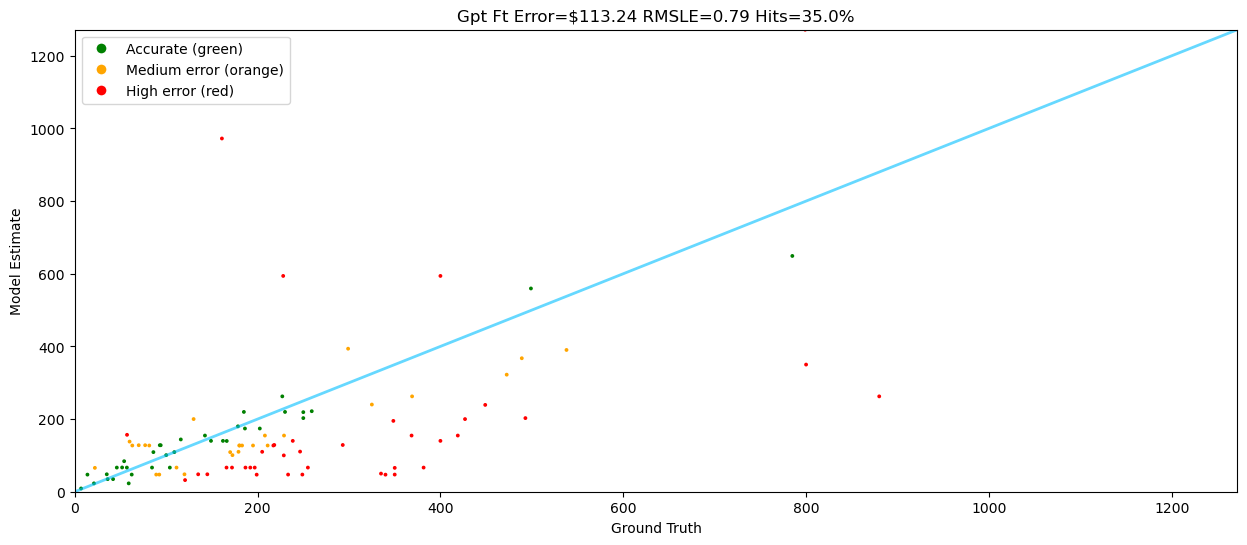

In [29]:
import helpers.testing
importlib.reload(helpers.testing)

from helpers.testing import Tester

tester = Tester(gpt_ft, test[:100])
tester.run()

![](assets/model_performance_comparison.png)

📉 Avrg error increased to 133, meaning the model actually performed worse than its zero-shot version.

At first, this was disappointing — but in reality, it was an enriching experiment.
We learned valuable techniques: data curation and cleaning, preparing data for fine-tuning, traditional ML workflows, evaluation metrics, and the complete fine-tuning pipeline for LLMs.

So no regrets — just progress. 💡

⚠️ **When Fine-Tuning Isn't Necessary**:

For this specific task (price prediction from product descriptions), large pre-trained models like GPT-4o already perform well out of the box, thanks to:
- Massive pretraining on diverse data
- Strong generalization ability
- Clear prompting capabilities

👉 In such cases, a **well-crafted prompt** is often more effective and efficient than full fine-tuning.

✅ **When Fine-Tuning Is Worth It (based on OpenAI’s own guidelines)**
- Custom tone/style – e.g., mimicking a brand voice or writing like a specific author
- More consistent output – e.g., always following a strict format
- Fix prompt failures – e.g., when multi-step instructions get ignored
- Handle edge cases – e.g., rare product types or weird inputs
- Teach new tasks – e.g., estimating prices in a custom format no model has seen before

# 🏁 Conclusion
Fine-tuning didn’t boost GPT-4o Mini’s performance for this task — but **the journey was rich.**

📚 We gained hands-on experience, deeper understanding, and clear insight:➡️ For some tasks, **prompting a strong frontier model is more effective than fine-tuning it.**

💡 **Choose fine-tuning only when prompting hits a wall — not by default.**